<a href="https://colab.research.google.com/github/scarfboy/wetsuite-dev/blob/main/examples/dataset_docstructure_cvdr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal of this notebook
Give an overview of the structure of the text documents (in XML form) in the CVDR repository,
and some ideas of how to process that as more than flat text.


### Why do this?

**What do these XML documents actually give us?**

In terms of natural language, legal texts are fairly precise and decently structured, by merit of needing to be unambiguous. What XML can and often does add to that is grouping natural sentences into ever narrower portions, like like chapters and paragraphs, structuring lists and tables.


**What might we want to do?**

The amount you care about this structure would vary with your research question
  - e.g. to summarize the subjects mentioned, you might only care about the words and phrases in it

  - to categorize portions of a document (say policy into introduction, motivation, implementation details, or case law into claim, court judgment, etc), we may only care to distinguish) we may only care to separate section

  - You might to group adjacent paragraphs (well, alineas - there's some loss in translation here) when they belong to the same portion/argument - this would certainly be easier to do if you still have the document structure
  
  - to find the most normative statements, and extract their meaning, you care more about structure and context

  - in laws, you might very much like to keep "this text comes from from article 1, lid 4"
  

**What can we add?**

We should certainly make an effort to make typical tasks easier

It should also be pointed out that we can only do so much.
The more precise your research question the more you may have to dig into the details.

Regardless of your question, you may run into the fact that while _in theory_ this all gives you fragments of well-defined and self-contained text,
in practice things are messier. People are quite pragmatic and gloss over a lot (consider e.g. how you would interpret the list in artikel 2 lid 2 in the first example below), but code tends to be stupidly literal.

So let's look at some documents, and see what is necessary.

## CVDR

In [ ]:
!pip3 --quiet install -U https://github.com/scarfboy/wetsuite-dev/archive/refs/heads/main.zip


In [2]:
import collections, random, pprint
 
import wetsuite.helpers.net
import wetsuite.helpers.etree
import wetsuite.helpers.koop_parse
import wetsuite.datacollect.koop_repositories

### What does a document look like?

Let's start with a single, cherry-picked, relatively clean and simple example

In [3]:
url = 'https://repository.officiele-overheidspublicaties.nl/CVDR/CVDR621050/2/xml/CVDR621050_2.xml'
example_tree = wetsuite.helpers.etree.fromstring( wetsuite.helpers.net.download( url ) )

# print the document mostly as we fetched it, reindented to make the structure more visual 
#   (note: you shouldn't reindent during data processing because it changes the document)
print( wetsuite.helpers.etree.tostring( wetsuite.helpers.etree.indent( example_tree ) ).decode('u8') ) 

<cvdr xmlns="http://standaarden.overheid.nl/cvdr/terms/" xmlns:dcterms="http://purl.org/dc/terms/" xmlns:overheid="http://standaarden.overheid.nl/owms/terms/" xmlns:overheidrg="http://standaarden.overheid.nl/cvdr/meta/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://standaarden.overheid.nl/cvdr/terms/  http://decentrale.regelgeving.overheid.nl/cvdr/xsd/cvdr.xsd">
  <!--export0.92-->
  <meta xmlns:msxsl="urn:schemas-microsoft-com:xslt" xmlns:xhtml="http://www.w3.org/1999/xhtml">
    <owmskern>
      <dcterms:identifier>CVDR621050_2</dcterms:identifier>
      <dcterms:title>Verordening van de raad, het college van burgemeester en wethouders en de burgemeester over de taken en bevoegdheden van de commissie bezwaarschriften (Verordening commissie bezwaarschriften Heemstede 2022)</dcterms:title>
      <dcterms:language>nl</dcterms:language>
      <dcterms:type scheme="overheid:Informatietype">regeling</dcterms:type>
      <dcterms:creator scheme="overheid:G

In [ ]:
# We are less interested in the metadata right now, so let's look at just the body contents.
# Let's also remove namespaces  (...to be consistent with other tutorials, they don't actually seem to be used in the body)
example_tree = wetsuite.helpers.etree.strip_namespace( example_tree )

body = example_tree.find('body')
print( wetsuite.helpers.etree.tostring( wetsuite.helpers.etree.indent( body ) ).decode('u8') ) # print just the body

<body>
  <intitule>Verordening van de raad, het college van burgemeester en wethouders en de burgemeester over de taken en bevoegdheden van de commissie bezwaarschriften (Verordening commissie bezwaarschriften Heemstede 2022)</intitule>
  <regeling>
    <aanhef>
      <preambule>
        <al>De raad, het college en de burgemeester van de gemeente Heemstede;</al>
        <al>ieder voor zover het hun bevoegdheden betreft;</al>
        <al>gelezen het voorstel van het college van 17 november 2015, 18 december 2018 en 10 mei 2022;</al>
        <al>gelet op artikel 7:13 van de Algemene wet bestuursrecht (Awb);</al>
        <al/>
        <al>besluiten vast te stellen de volgende verordening:</al>
        <al/>
        <al>Verordening commissie bezwaarschriften Heemstede 2022</al>
      </preambule>
    </aanhef>
    <regeling-tekst>
      <artikel>
        <kop>
          <label>Artikel</label>
          <nr>1</nr>
          <titel>Begripsbepalingen</titel>
        </kop>
        <al>In deze

#### Some side questions (you can skip this)

First question: is that a structure that always looks like that, or does it act more like a free-form document in the sense of allowing whatever you put in?

There is an XML schema (e.g. [included here; TODO: find in XML form](https://www.koopoverheid.nl/binaries/koop/documenten/instructies/2017/10/23/cvdr-handleiding-deel-6-deel-6-metadata-xml-schema-en-webservices/IPM_dr_4_0_deel_6-Metadata_XML-schema_Webservices-1.pdf) that should help answer that (a schema settling things like which elements are allowed to appear in the context of which others).

It's long and seems detailed, and is technically useful, but also not very readable, and it turns out it's relatively forgiving in which elements are used to narrow down, and how many. 
Let's show rather than tell:

From the above, we have the question of how consistent the parts under `regeling` are - are things always structured the same, or not?

Let's load a bunch of documents, and count the path you have to walk *between* `regeling` to each child node, to get a feel of both common and uncommon nesting.

In [ ]:
# Fetch a large amoubnt of documents,
#  parse into etree objects (keep in memory so we can saves some time when doing different counts on the same documents)
# There are currently roughly 150k CVDR works, which is a little much to all load at once, so we do a sample
# TODO: replace with fetches from dataset (and TODO: make that dataset), so that you can actually run this. 
#   For now you'll have to trust the larger samples.
conn = wetsuite.datacollect.db.connect()
curs = conn.cursor()
curs.execute('SELECT xml_url  FROM cvdr')
cvdr_urls = curs.fetchall()
conn.rollback()

cvdr_parsed = [] # list of (source url, etree object) tuples
for url, in random.sample(cvdr_urls, 20000): # a sizeable random selection should be enough
    bytestring, _, _ = wetsuite.datacollect.db.cached_fetch( url )
    tree = wetsuite.helpers.etree.fromstring( bytestring )
    tree = wetsuite.helpers.etree.strip_namespace( tree )
    cvdr_parsed.append( (url, tree) )

In [ ]:
# Run the path counter.__name__
#  First questions: how common are each of the broad parts in the regeling?
#  Stopping two-deep should answer that cleanly.
count_paths = collections.defaultdict( int )

for url, tree in cvdr_parsed:
    for path, count in wetsuite.helpers.etree.path_count( tree.find('body/regeling'), max_depth=2 ).items():
        count_paths[path] += count

for path, count in sorted( count_paths.items() ):
    print( '%6d  %s'%(count,path))

 20000  regeling
 20000  regeling/aanhef
 10643  regeling/bijlage
  3543  regeling/nota-toelichting
 14653  regeling/regeling-sluiting
 20000  regeling/regeling-tekst


In [ ]:
# Out of curiosity, what's in the aanhef?
count_paths = collections.defaultdict( int )
for url, tree in cvdr_parsed:
    for path, count in wetsuite.helpers.etree.path_count( tree.find('body/regeling/aanhef'), max_depth=4 ).items():
        count_paths[path] += count

for path, count in sorted( count_paths.items() ):
    print( '%6d  %s'%(count,path))

 20000  aanhef
   924  aanhef/afkondiging
  4187  aanhef/afkondiging/al
    20  aanhef/afkondiging/al/cursief
     2  aanhef/afkondiging/al/extref
     1  aanhef/afkondiging/al/noot
    47  aanhef/afkondiging/al/onderstreept
     7  aanhef/afkondiging/al/plaatje
     3  aanhef/afkondiging/al/sup
   932  aanhef/afkondiging/al/vet
    75  aanhef/afkondiging/lijst
   187  aanhef/afkondiging/lijst/li
 19998  aanhef/preambule
182690  aanhef/preambule/al
  1653  aanhef/preambule/al/cursief
  1702  aanhef/preambule/al/extref
    21  aanhef/preambule/al/inf
    51  aanhef/preambule/al/noot
   546  aanhef/preambule/al/onderstreept
   103  aanhef/preambule/al/plaatje
   191  aanhef/preambule/al/sup
 22379  aanhef/preambule/al/vet
     2  aanhef/preambule/kop
     2  aanhef/preambule/kop/label
  5842  aanhef/preambule/lijst
 18799  aanhef/preambule/lijst/li
    46  aanhef/wie
    12  aanhef/wij


So broadly, the body seems to contain
* `intitule`
* `regeling`
  * `aanhef` (apparently always there), mostly `preambule` text
  * `regeling-tekst` is the main text (always there), more on that below
  * `regeling-sluiting` is some formalities (usually there)
  * `bijlage` may be additional useful stuff (there half the time)

#### The main question

Our initial question was about the paths under `regeling-tekst`

In [ ]:
count_paths = collections.defaultdict( int )

for url, tree in cvdr_parsed:
    for path, count in wetsuite.helpers.etree.path_count( tree.find('body/regeling/regeling-tekst') ).items():
        count_paths[path] += count

for path, count in sorted( count_paths.items() ):
    if count > 100:
        print( '%6d  %s'%(count,path))

 20000  regeling-tekst
   137  regeling-tekst/afdeling/artikel
   137  regeling-tekst/afdeling/artikel/kop
   137  regeling-tekst/afdeling/artikel/kop/label
   114  regeling-tekst/afdeling/artikel/kop/nr
   149  regeling-tekst/afdeling/artikel/lid
   155  regeling-tekst/afdeling/artikel/lid/al
   149  regeling-tekst/afdeling/artikel/lid/lidnr
   112  regeling-tekst/afdeling/paragraaf/artikel/lid
   115  regeling-tekst/afdeling/paragraaf/artikel/lid/al
   112  regeling-tekst/afdeling/paragraaf/artikel/lid/lidnr
115896  regeling-tekst/artikel
300322  regeling-tekst/artikel/al
 10255  regeling-tekst/artikel/al/cursief
   318  regeling-tekst/artikel/al/cursief/onderstreept
  1750  regeling-tekst/artikel/al/extref
   136  regeling-tekst/artikel/al/extref/cursief
   114  regeling-tekst/artikel/al/extref/onderstreept
   255  regeling-tekst/artikel/al/noot
   257  regeling-tekst/artikel/al/noot/noot.al
   255  regeling-tekst/artikel/al/noot/noot.nr
  3781  regeling-tekst/artikel/al/onderstreep

### Extracting things

#### What's necessary to get out just text?

What if we selected all the `<al>` tags and extracted their `.text` ?

In [ ]:
# use a helper that virualizes a selection within an etree, to see if our selection makes sense
#  (note: this works only if we're in an ipython style notebook)
wetsuite.helpers.notebook.etree_visualize_selection( example_tree, 'body/regeling/regeling-tekst//al', reindent=True, mark_subtree=True )

#### What about the structure?

The above xpath select happens to be fairly *selective*, yet we are also interested to pick out the structure it's from.

If you're used to both this sort of legal text, and xml, 
then your eyes may glide ofer to check the `artikel/nr` and `lid/lidnr` for the part you want,
but doing such a 'the part I'm interested in' lookup in code on just the XML is easily quite awkward.

So let's try to make that simpler.

In [4]:
more_complex_example_tree = wetsuite.helpers.etree.fromstring( 
    wetsuite.helpers.net.download( 'https://repository.officiele-overheidspublicaties.nl/CVDR/CVDR11313/52/xml/CVDR11313_52.xml' )
)

alinea_dicts = wetsuite.helpers.koop_parse.alineas_with_selective_path( more_complex_example_tree, start_at_path='body/regeling/regeling-tekst' )

/usr/local/lib/python3.8/dist-packages/wetsuite/helpers/koop_parse.py:843: UserWarning: The behaviour of alineas_with_selective_path() is not fully decided, and may still change
  warnings.warn('The behaviour of alineas_with_selective_path() is not fully decided, and may still change')


In [5]:
# This returns a dict, one for each al tag, detailing where it came from. They look like:
for alinea_dict in alinea_dicts[:10]: # show just a handful, let's not spam too much
    print('-'*80)
    pprint.pprint( alinea_dict )

--------------------------------------------------------------------------------
{'merged': {'artikellabel': 'Artikel',
            'artikelnr': '1:1',
            'artikeltitel': 'Begripsomschrijvingen',
            'hoofdstuklabel': 'Hoofdstuk',
            'hoofdstuknr': '1',
            'hoofdstuktitel': 'Algemene bepalingen'},
 'parts': [{'hoofdstuklabel': 'Hoofdstuk',
            'hoofdstuknr': '1',
            'hoofdstuktitel': 'Algemene bepalingen',
            'what': 'hoofdstuk'},
           {'artikellabel': 'Artikel',
            'artikelnr': '1:1',
            'artikeltitel': 'Begripsomschrijvingen',
            'what': 'artikel'}],
 'path': '/cvdr/body/regeling/regeling-tekst/hoofdstuk[1]/artikel[1]/al',
 'text-flat': 'In deze verordening wordt verstaan dan wel mede verstaan onder:'}
--------------------------------------------------------------------------------
{'merged': {'artikellabel': 'Artikel',
            'artikelnr': '1:1',
            'artikeltitel': 'Begripsomsc

This is roughly *all* the detail, and alineas can clearly be overly split up, highlighting the need for an ability to merge these.

In [13]:
# the merge_alinea_data() function
# - merge everything that has the same values for the same structural elements, down to a specified level,
#   because the default is 'down to lid', this mostly just merges flattening lists and tables, and join alineas if there are multiple)
#   and in this particular document means "if it has the same values for hoofdstuk, artikel, and lid"

#   - this is controllable, TODO: make easier, and then make an example how
# - mentiones the larger structural elements that flat text belongs to
pprint.pprint( wetsuite.helpers.koop_parse.merge_alinea_data( alinea_dicts )[50:100] ) # those indices give a small selection

[([('hoofdstuk', ''),
   ('afdeling', '2'),
   ('paragraaf', '5:'),
   ('artikel', '2:10A.'),
   ('lid', '5.')],
  ['Het college van burgemeester en wethouders stelt voor het leggen, hebben '
   'liggen of in enig opzicht wijzigen van leidingen nadere regels vast.']),
 ([('hoofdstuk', ''),
   ('afdeling', '2'),
   ('paragraaf', '5:'),
   ('artikel', '2:10A.'),
   ('lid', '6.')],
  ['Het college van burgemeester en wethouders beslist op een aanvraag:',
   'om instemming voor het leggen, hebben liggen of in enig opzicht wijzigen '
   'van een leiding binnen acht weken na ontvangst van de aanvraag;',
   'om instemming voor het leggen, hebben liggen of in enig opzicht wijzigen '
   'van een huisaansluiting van een leiding, waarvan de lengte niet langer is '
   'dan 55 meter, binnen drie werkdagen na ontvangst van de aanvraag.']),
 ([('hoofdstuk', ''),
   ('afdeling', '2'),
   ('paragraaf', '5:'),
   ('artikel', '2:10A.'),
   ('lid', '7.')],
  ['vervallen']),
 ([('hoofdstuk', ''),
   ('afde

[('hoofdstuk', '1')]


/usr/local/lib/python3.8/dist-packages/spacy/util.py:877: UserWarning: [W095] Model 'nl_core_news_md' (3.4.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.5.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


['deze verordening', 'de weg', 'artikel', 'eerste lid', 'b', 'de Wegenverkeerswet', 'parkeerterreinen', 'al dan niet met enige beperking', 'het publiek', 'toegankelijke pleinen', 'open plaatsen', 'parken', 'plantsoenen', 'speelweiden', 'bossen', 'andere natuurterreinen', 'ijsvlakten', 'aanlegplaatsen', 'vaartuigen', 'het publiek', 'trappen', 'portieken', 'gangen', 'passages', 'galerijen', 'die', 'bewoning', 'gebruik', 'ruimte', 'toegang', 'het publiek', 'afsluitbare stoepen', 'trappen', 'portieken', 'gangen', 'passages', 'galerijen', 'afsluitbare alleen gedurende de tijd', 'zij', 'die', 'burgerlijk recht', 'de weg', 'sub', 'deel', 'de daartoe behorende ondergrond', 'Openbaar water', 'alle wateren', 'die', 'al dan niet met enige beperking', 'het publiek', 'bevaarbaar', 'anderszins', 'eenieder', 'die', 'enige zaak', 'enige zeggenschap', 'een zakelijk of persoonlijk recht', 'alle voertuigen', 'artikel 1, onder', 'verkeerstekens', 'uitzondering', 'treinen', 'trams', 'kruiwagens', 'kinderwa

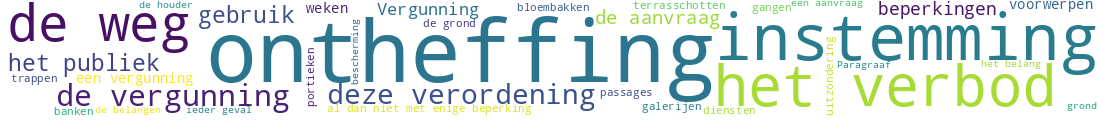

[('hoofdstuk', ''), ('afdeling', '2')]
['de weg', 'deel', 'een samenscholing', 'uitdagend gedrag', 'wanordelijkheden', 'die', 'de weg', 'enig voorval', 'wanordelijkheden', 'toeloop', 'publiek', 'aanleiding', 'wanordelijkheden', 'een samenscholing', 'een daartoe strekkend bevel', 'een ambtenaar', 'politie', 'zijn weg', 'de door hem aangewezen richting', 'een voorval', 'gebeurtenis', 'samenscholing', 'het tweede lid', 'de richting daarvan', 'voorwerpen', 'die', 'wanordelijkheden', 'een ketting', 'knuppel', 'helm', 'bivakmuts', 'terreinen', 'wegen', 'weggedeelten', 'die', 'het bevoegd gezag', 'het belang', 'de openbare veiligheid', 'voorkoming', 'wanordelijkheden', 'De burgemeester', 'ontheffing', 'het derde lid', 'de voorgaande leden', 'betogingen', 'vergaderingen', 'samenkomsten', 'de Wet', 'openbare manifestaties', 'die', 'het voornemen', 'een openbare plaats', 'artikel', 'Wet', 'openbare manifestaties', 'een betoging', 'vergadering', 'de artikelen', 'Wet', 'openbare manifestaties', 'd

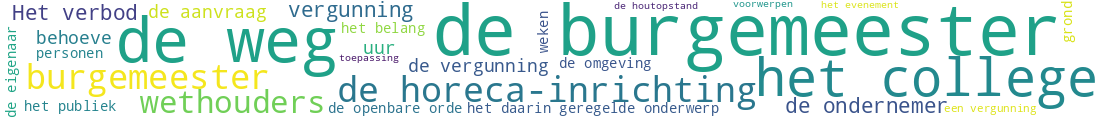

[('hoofdstuk', ''), ('afdeling', '2'), ('afdeling', '19')]
['dit artikel', 'natuurlijke persoon', 'de bestuurder', 'een rechtspersoon', 'toepassing', 'vertegenwoordiging', 'die rechtspersoon', 'wiens rekening', 'risico', 'de bedrijfsmatige activiteiten', 'beheerder', 'de natuurlijke persoon', 'die', 'de exploitant', 'de feitelijke leiding', 'de bedrijfsmatige activiteiten', 'bedrijf', 'het publiek', 'bedrijfsmatige activiteiten', 'die', 'de vergunningplicht', 'artikelen', 'horeca-inrichting', '3:4', 'seksinrichting', 'De burgemeester', 'gebieden', 'bedrijfsmatige activiteiten', 'het verbod', 'het derde lid', 'toepassing', 'Een gebouw', 'gebied', 'een bepaalde termijn', 'dat gebouw', 'dat gebied', 'het oordeel', 'de burgemeester', 'de leefbaarheid', 'de openbare orde', 'veiligheid', 'druk', 'Een aanwijzing', 'een gebouw', 'gebied', 'bedrijfsmatige activiteiten', 'Een bedrijfsmatige activiteit', 'de gehele gemeente', 'het oordeel', 'de burgemeester', 'de leefbaarheid', 'openbare orde', '

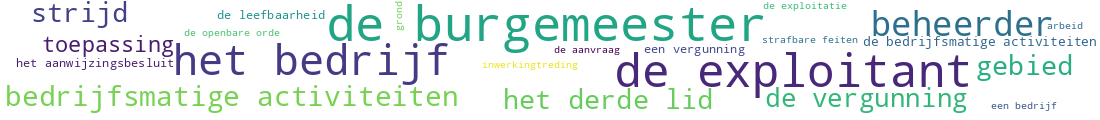

[('hoofdstuk', ''), ('afdeling', '3')]
['De artikelen', '1:2', '1:5', 'dit hoofdstuk', 'dit hoofdstuk', '- advertentie', 'elke commerciële uiting', 'een medium', 'die', 'een seksbedrijf', 'een prostituee', 'de aandacht', 'het publiek', 'beheerder', 'de natuurlijke persoon', 'die', 'de exploitant', 'de feitelijke leiding', 'een seksbedrijf', 'bevoegd bestuursorgaan', 'het college', 'het', 'het publiek', 'daarbij behorende erven', 'artikel', 'de burgemeester', 'bezoeker', 'die', 'een seksinrichting', 'uitzondering', 'de exploitant', 'de beheerder', 'de schoonmaker', 'de prostituee', 'de toezichthouder', '(', 's', ')', 'artikel', 'andere personen', 'wier aanwezigheid', 'de inrichting', 'dringende redenen', 'escortbedrijf', 'de activiteit', 'het bedrijfsmatig gelegenheid', 'prostitutie', 'de vorm', 'bemiddeling', 'klant', 'prostituee', 'exploitant', 'de natuurlijke persoon', 'de bestuurder', 'een rechtspersoon', 'toepassing', 'vertegenwoordiging', 'die rechtspersoon', 'wiens rekening', 'ri

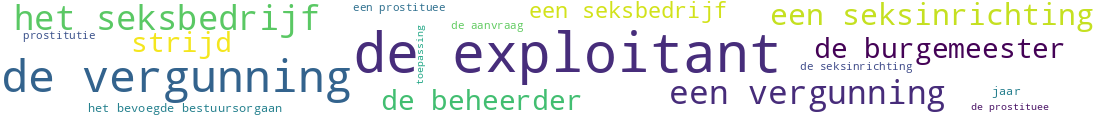

[('hoofdstuk', ''), ('afdeling', '4')]
['deze afdeling', 'Besluit', 'inrichting', 'een inrichting', 'type', 'het Besluit', 'hoofdcategorie', 'horeca', 'categorie', 'bijlage', 'onderdeel', 'C', 'het Besluit', 'omgevingsrecht', 'houder', 'een inrichting', 'die', 'bedrijfsleider', 'beheerder', 'een inrichting', 'collectieve festiviteit', 'festiviteit', 'die', 'een klein aantal', 'inrichtingen', 'individuele festiviteit', 'festiviteit', 'activiteit', 'die', 'een klein aantal', 'inrichtingen', 'toeristische gebieden', 'uitgaanskernen', 'toeristische gebieden', 'binnenstad', 'uitgaanskernen', 'seizoensgebonden strandpaviljoen', 'bewoning', 'overdekte stellage', 'het strand', 'behoeve', 'de verstrekking van etenswaren en dranken voor gebruik ter', 'plaatse', 'zaalexploitatie', 'de vorm', 'een horeca-inrichting', 'De geluidsnormen', 'de artikelen', '2.19a', 'het Besluit', 'het college', 'kalenderjaar', 'collectieve festiviteiten', 'de daarbij aan te wijzen dagen', 'dagdelen', 'een aanwijzing',

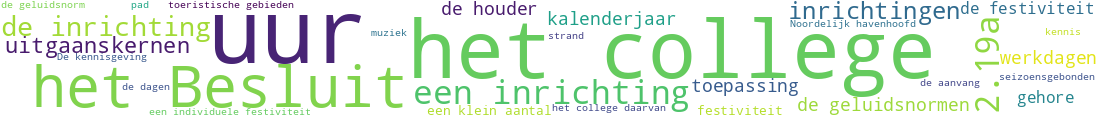

[('hoofdstuk', ''), ('afdeling', '5')]
['deze afdeling', 'de weg', 'artikel 1, eerste lid onder', 'b', 'de Wegenverkeerswet', 'voertuigen', 'alle voertuigen', 'uitzondering', 'treinen', 'trams', 'bromfietsen', 'de zin', 'het Reglement', 'verkeersregels', 'verkeerstekens', 'kruiwagens', 'kinderwagens', 'dergelijke kleine voertuigen', 'rolstoelen', 'een voertuig, anders', 'de tijd', 'die', 'passagiers', 'goederen', 'Het', 'die', 'bedrijf', 'nevenbedrijf', 'een gewoonte', 'maakt voertuigen', 'voertuigen', 'die', 'toebehoren', 'de weg', 'een cirkel', 'een straal', 'meter', 'middelpunt', 'een dezer voertuigen', 'de weg', 'werkplaats', 'voertuigen', 'het eerste lid', 'een voertuig', 'lessen', 'een voertuig', 'personen', 'betaling', 'de voertuigen', 'het eerste lid', 'voertuigen', 'onderhoudswerkzaamheden', 'die', 'totaal', 'een uur', 'de tijd', 'die', 'deze werkzaamheden', 'voertuigen', 'persoonlijk gebruik', 'het eerste lid', 'Het college', 'het eerste lid', 'ontheffing', 'Het', 'het colleg

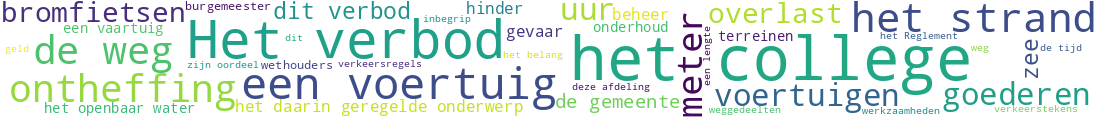

[('hoofdstuk', ''), ('afdeling', '6')]
['Overtreding', 'de volgende artikelen', 'grond', 'voorschriften', 'beperkingen', 'hechtenis', 'ten hoogste drie maanden', 'geldboete', 'de tweede categorie', 'openbaarmaking', 'de rechterlijke uitspraak', 'artikel 2:1, 2:3, 2:6, 2:8, 2:10, 2:10B, 2:11, 2:12, 2:18, 2:25, 2:25B, 2:26, 2:26A, 2:26B, 2:28, 2:29, 2:30, 2:30A, 2:31, 2:32, 2:33, 2:37, 2:38, 2:38A, 2:38B, 2:41, 2:44, 2:48, 2:49, 2:50, 2:52, 2:67, 2:68, 2:69, 2:72, 2:73, 2:73A, 2:73B, 2:74, 2:74A, 2:74B, 2:74C, 2:75, 2:79, 2:98, 3:3, 3:8, 3:10, 3:11', '3:12', '3:16', '3:19', '4:4', '4:6', '5:2', '5:7', '5:10A', '5:37', 'eerste lid', 'derde lid', 'Overtreding', 'de volgende artikelen', 'grond', 'voorschriften', 'beperkingen', 'een geldboete', 'de eerste categorie', 'artikel 2:8, 2:9, 2:13, 2:14, 2:15, 2:16, 2:17, 2:19, 2:20, 2:21, 2:23, 2:23A., 2:42, 2:43, 2:45, 2:46, 2:47, 2:47A., 2:51, 2:53, 2:56, 2:57, 2:58, 2:59, 2:65, 2:65A., 4:8, 4:9, 4:10, 5:4, 5:5, 5:6, 5:10, 5:11', '5:40', 'tweede

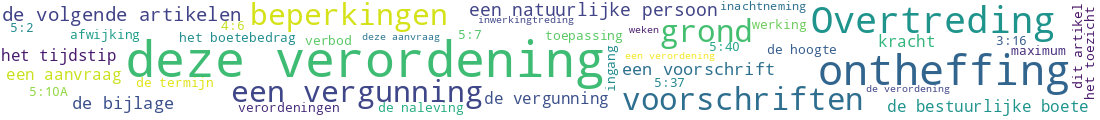

In [28]:
import wetsuite.helpers.koop_parse
import wetsuite.extras.word_cloud
import wetsuite.helpers.spacy

from importlib import reload
reload(wetsuite.extras.word_cloud)
reload(wetsuite.helpers.spacy)

stopwords = wetsuite.extras.word_cloud.stopwords_nl + (
    'Artikel','artikel','de artikelen',  'eerste lid', 'het eerste lid', 'tweede lid',  'wet', 'de Wet', 'Het',  'zij',
)

for meta_ary, text_ary in wetsuite.helpers.koop_parse.merge_alinea_data( alinea_dicts, if_same={'hoofdstuk':'hoofdstuknr', 'afdeling':'afdelingnr',}  ):
    print( meta_ary )
    text = ' '.join( text_ary )
    nc = wetsuite.helpers.spacy.nl_noun_chunks(text)
    print(nc)
    #tokens = wetsuite.extras.word_cloud.simple_tokenize(text)
    counts = wetsuite.extras.word_cloud.count_case_insensitive( nc, stopwords=stopwords )
    im = wetsuite.extras.word_cloud.wordcloud_from_freqs( counts, 1100, 120 )
    display( im )

In [ ]:
# If you care _only_ about the text you can do it a little simpler:
for alinea_dict in alinea_dicts:
    print( alinea_dict['text-flat'] )

In deze verordening wordt verstaan dan wel mede verstaan onder:
a.
Weg:


1.
de weg, als bedoeld in artikel 1, eerste lid, onder b, van de Wegenverkeerswet 1994, alsmede de daaraan liggende en als zodanig aangeduide parkeerterreinen;

2.
de - al dan niet met enige beperking - voor het publiek toegankelijke pleinen en open plaatsen, parken, plantsoenen, speelweiden, bossen en andere natuurterreinen, ijsvlakten en aanlegplaatsen voor vaartuigen;

3.
de voor het publiek toegankelijke stoepen, trappen, portieken, gangen, passages en galerijen, die uitsluitend tot voor bewoning in gebruik zijnde ruimte toegang geven en niet afsluitbaar zijn;

4.
andere voor het publiek toegankelijke, al dan niet afsluitbare stoepen, trappen, portieken, gangen, passages en galerijen; de afsluitbare alleen gedurende de tijd dat zij niet door of vanwege degene die daartoe naar burgerlijk recht bevoegd is, zijn afgesloten.

5.
van de weg zoals bedoeld in sub a, onder 1 tot en met 4, maakt deel uit de daartoe be

#### Other examples you may wish to try

In [ ]:
# Example with afdeling
# https://repository.officiele-overheidspublicaties.nl/CVDR/CVDR386553/5/xml/CVDR386553_5.xml


# Example with afdeling, hoofdstuk, paragraaf -- which also seems to (wildly) abuse them as each other
# https://repository.officiele-overheidspublicaties.nl/CVDR/CVDR11313/52/xml/CVDR11313_52.xml


# example with titeldeel, afdeling (and some )
# https://repository.officiele-overheidspublicaties.nl/CVDR/CVDR142369/1/xml/142369_1.xml


# Example with nested afdelingen - e.g. regeling-tekst/hoofdstuk/afdeling/paragraaf/afdeling/artikel/kop/titel/vet
# 'https://repository.officiele-overheidspublicaties.nl/CVDR/CVDR297855/7/xml/CVDR297855_7.xml'

